# Facial keypoints detection
# Preparation
## Libraries import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torchvision import transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
import time
import cv2
import os
from zipfile import ZipFile
import gc

gc.collect()

0

## Environment settings

In [3]:
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print("Running a Kaggle Notebook/Script - Could be Interactive or Batch Mode")
    host = 'Kaggle'
    inp = '../input/'
    dir = ''
    frame_color = 'black'
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
        print("Running a Kaggle Notebook/Script - Interactive Mode")

    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
        print("Running a Kaggle Notebook/Script - Batch Mode")

else:
    try:
        import google.colab
        host = 'Colab'
        drive.mount('/content/drive')
        dir = 'drive/MyDrive/studies/My projects/Kaggle/Facial_keypoints/'
        frame_color = 'black'
        inp = ''
        print("Running on Colab")
    except ModuleNotFoundError:
        host = None
        dir = ''
        inp = ''
        frame_color = 'white'
        print("Running on Localhost")

gpu = torch.cuda.is_available()
print('GPU: ' + str(gpu))

Running a Kaggle Notebook/Script - Could be Interactive or Batch Mode
Running a Kaggle Notebook/Script - Interactive Mode
GPU: True


## Read the data

In [4]:
with ZipFile(inp + 'facial-keypoints-detection/test.zip', 'r') as zipObj:
   zipObj.extractall()
with ZipFile(inp + 'facial-keypoints-detection/training.zip', 'r') as zipObj:
   zipObj.extractall()
train_and_val_csv = pd.read_csv(dir + 'training.csv')
test_csv = pd.read_csv(dir + 'test.csv')
print('Train and validation set length {}'.format(len(train_and_val_csv)))
print('Test set length {}'.format(len(test_csv)))

Train and validation set length 7049
Test set length 1783


## Train and test set info

In [5]:
print(train_and_val_csv.info())
print(test_csv.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

## New train set

In [6]:
auto_fill = train_and_val_csv.ffill()
full_only = train_and_val_csv.dropna()
missing_only = train_and_val_csv[train_and_val_csv.isna().sum(axis=1) != 0]
# missing_only = missing_only.fillna(method='ffill').fillna(method='bfill')

print(auto_fill.shape)
print(missing_only.shape)
print(full_only.shape)


(7049, 31)
(4909, 31)
(2140, 31)


## DataLoader

In [7]:
def get_keypoints_features(keypoint_data):
    keypoint_features = []
    for _, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)

    keypoint_features = np.array(keypoint_features, dtype="float")
    return keypoint_features

class FaceKeypointDataSet(torch.utils.data.Dataset):
    def __init__(self, data, transformer=None, transformer_factor=None, is_test_set=False):
        imgs = data.Image
        imgs = np.array(imgs)
        for j in range(len(imgs)):
            imgs[j] = np.fromstring(imgs[j], sep = ' ')
        self.image_data = imgs
        self.feature_data = data.drop(['Image'], axis=1)
        self.transformer = transformer
        self.transformer_factor = transformer_factor
        self.is_test_set = is_test_set
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self,index):
        img =  self.image_data[index]
        img = img.astype(np.uint8).reshape(96,96)
        img = self.transform(img)
        if self.is_test_set:
                return img
        feature = np.array(self.feature_data.iloc[index])
        if self.transformer is not None:
            img, feature = self.transformer(img,feature,self.transformer_factor)
        return img, feature

original_train_data = FaceKeypointDataSet(train_and_val_csv, transformer=None)


# Augmentation
### Help functions

In [8]:
all_datasets = []
def create_aug_sets(aug_transformer, params):
    aug_sets = []
    for param in params:
        aug_data = FaceKeypointDataSet(train_and_val_csv, transformer=aug_transformer,
                                       transformer_factor=param)
        aug_sets.append(aug_data)
    show_aug(aug_sets)
    global all_datasets
    all_datasets += aug_sets
    return aug_sets

def show_img_and_features(data, img_index):
    plt.imshow(data[img_index][0].reshape(96, 96), cmap='gray')
    plt.scatter(data[img_index][1][::2], data[img_index][1][1::2], marker='o', s=100)

def show_aug(datasets):
    '''
    Show the diffrence between the augmented dataset to the original
    '''
    fig = plt.figure(figsize=(10, 20))
    plt.tight_layout()
    num_of_datasets = len(datasets)
    rand_img = np.random.randint(0, len(original_train_data))
    for index, aug_data in enumerate(datasets):
        fig.add_subplot(num_of_datasets, 2, (index + 1) * 2 - 1)
        show_img_and_features(original_train_data, rand_img)
        fig.add_subplot(num_of_datasets, 2, (index + 1) * 2)
        show_img_and_features(aug_data, rand_img)
    plt.show()


### Horizontal flip

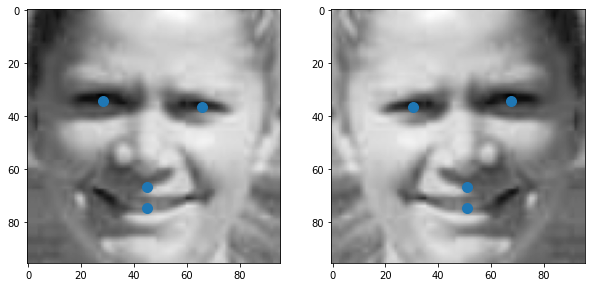

In [9]:
original_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
flip_index = [2,3,0,1,8,9,10,11,4,5,6,7,16,17,18,19,12,13,14,15,20,21,24,25,22,23,26,27,28,29]

def flip_aug(img, fea, factor):
    img = np.array(img)
    img = img[:,:,::-1]
    img = torch.tensor(img.copy()).reshape(1,96,96)
    fea = fea[flip_index]
    fea[::2] = 96 - fea[::2]
    return img, fea

transformer_params = [None]
aug_sets = create_aug_sets(flip_aug, transformer_params)

### Add noise

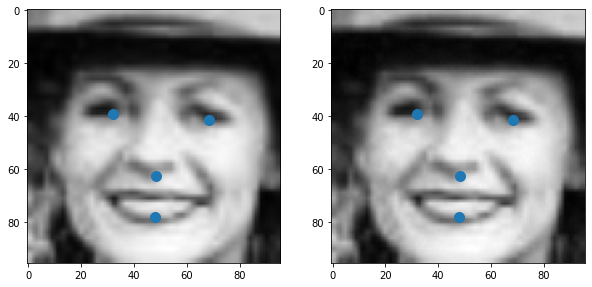

In [10]:
def noise_aug(img, fea, factor):
    img = np.array(img)
    img = img + 0.008 * np.random.randn(1,96,96)
    img = torch.tensor(img.copy(),dtype=torch.float32).reshape(1,96,96)
    return img, fea

transformer_params = [None]
aug_sets = create_aug_sets(noise_aug, transformer_params)


### Brightness trim

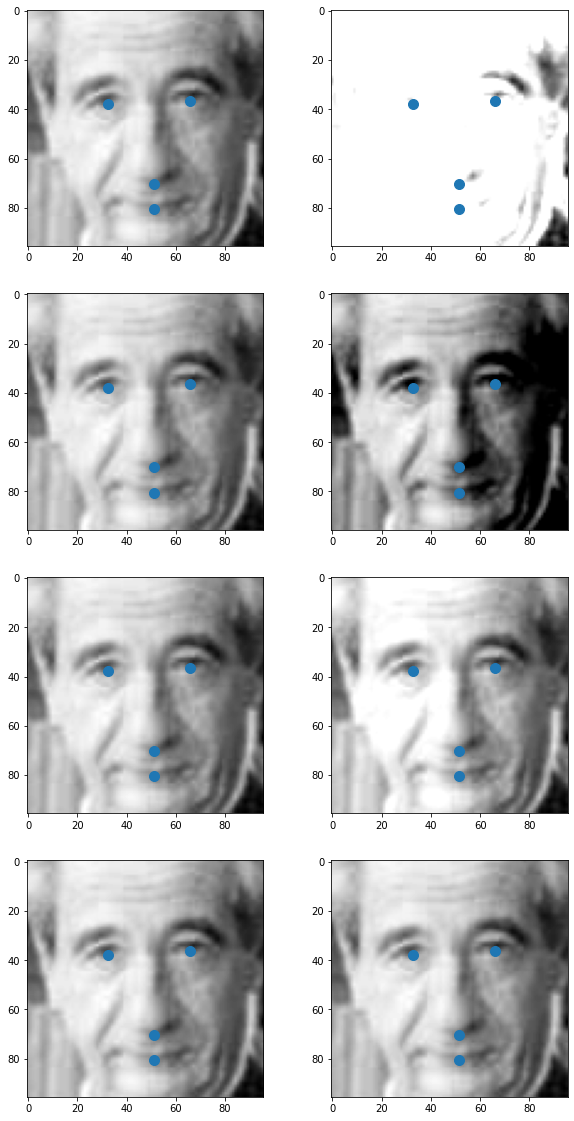

In [11]:
def brightness_aug(img, fea, factor):
    img = np.clip(img + factor, -1, 1)
    img = img.reshape(1,96,96)
    return img, fea

transformer_params = [1, -1, 0.5, -0.5]
aug_sets = create_aug_sets(brightness_aug, transformer_params)


### Rotate

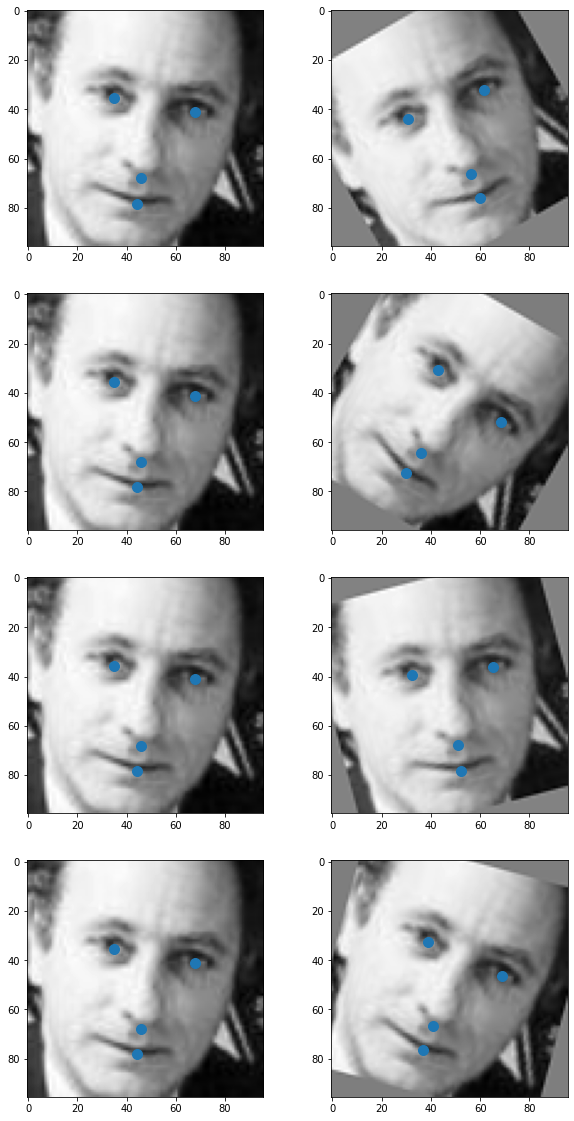

In [12]:
def rotate_aug(img, fea, factor=-30):
    rad = -factor/180 * np.pi
    rot = cv2.getRotationMatrix2D((48,48),factor,1)
    img = cv2.warpAffine(np.array(img).reshape(96,96),rot,(96,96),flags=cv2.INTER_CUBIC)
    img = torch.tensor(img).reshape(1,96,96)
    fea -= 48
    for index in range(0,len(fea),2):
        x = fea[index]
        y = fea[index + 1]
        fea[index] = x * np.cos(rad) - y * np.sin(rad)
        fea[index + 1] = x * np.sin(rad) + y * np.cos(rad)
    fea += 48
    return img,fea

transformer_params = [30, -30, 15, -15]
aug_sets = create_aug_sets(rotate_aug, transformer_params)


## Arrange the data

In [13]:
tav_split = 0.65
indices = list(range(len(full_only)))
np.random.shuffle(indices)
split = int(np.floor((1 - tav_split) * len(full_only)))
train_indices, val_indices = indices[split:], indices[:split]
train_full = full_only.iloc[train_indices]
val_sampler =  SequentialSampler(val_indices)
missing_set = FaceKeypointDataSet(missing_only, transformer=None)
train_full_set = FaceKeypointDataSet(train_full, transformer=None)
full_only_set = FaceKeypointDataSet(full_only,transformer=None)
all_datasets.append(missing_set)
all_datasets.append(train_full_set)
train_data = torch.utils.data.ConcatDataset(all_datasets)
train_sampler = SubsetRandomSampler(range(len(train_data)))
print(f"Train set length: {len(train_data)}")
print(f"Validation set length: {len(val_indices)}")
del indices, train_indices, train_full, train_full_set, val_indices,\
    missing_set, all_datasets, original_train_data
gc.collect()

Train set length: 76790
Validation set length: 749


55601

## Constract the loader

In [14]:
if gpu:
    batch_size = 256
else:
    batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(full_only_set, batch_size=batch_size, sampler=val_sampler)
del full_only_set, train_data,val_sampler,train_sampler
gc.collect()
print('Data loader is ready, wait for saving')
torch.save(val_loader, 'val_loader.pt')
print('Val loader is saved')

Data loader is ready, wait for saving
Val loader is saved


# Data visualization

## Help function

In [15]:
def visualize_examples(images, features, pred_labels=None):
    '''
    Make 16 images and labels examplesf= from the input,
    if the input includes predicted labels - show them with x marks
    '''
    fig = plt.figure(figsize=(20,10))
    for i in range(16):
        fig.add_subplot(4, 4, i + 1)
        plt.imshow(images[i].reshape(96, 96), cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.scatter(features[i][::2], features[i][1::2], marker='o', s=100)
        if pred_labels is not None:
                plt.scatter(pred_labels[i][::2], pred_labels[i][1::2], marker='x',color='red', s=100)

    plt.show()

## Some examples

Training set


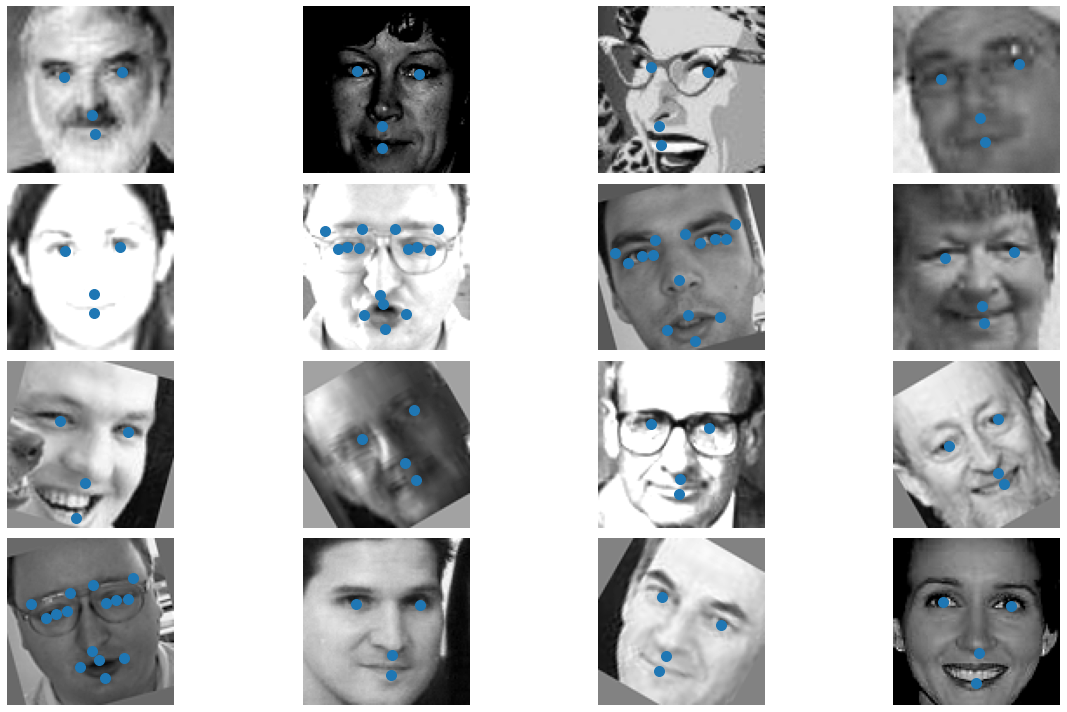

Validation set


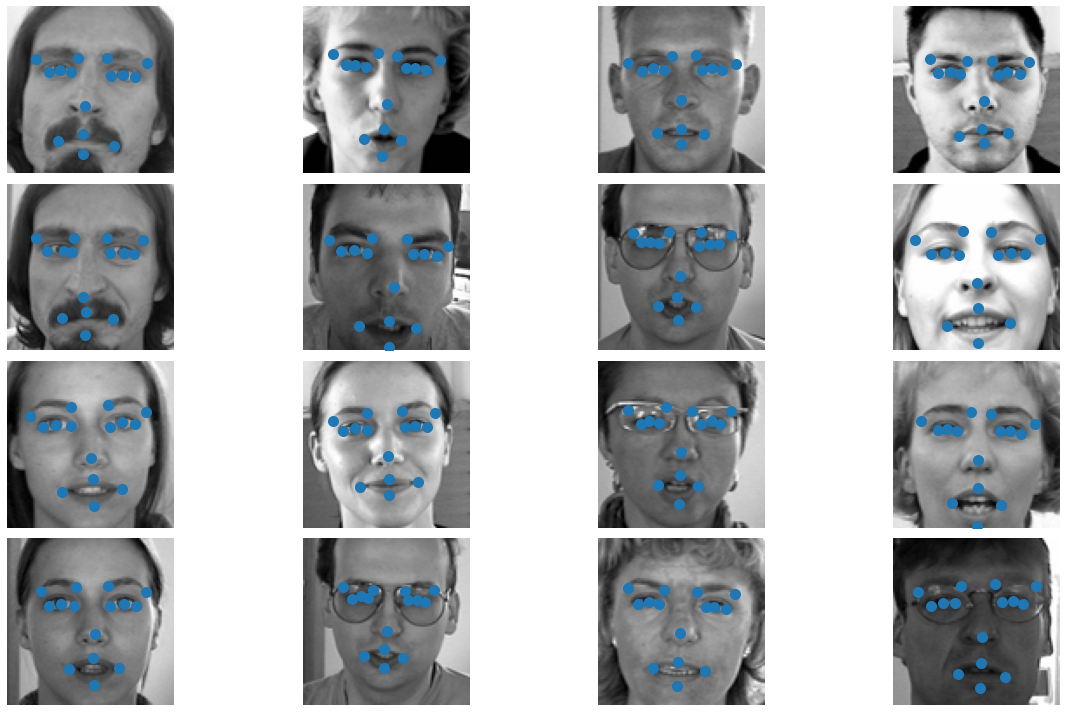

In [16]:
print('Training set')
images, features = next(iter(train_loader))
visualize_examples(images, features)
print('Validation set')
images, features = next(iter(val_loader))
visualize_examples(images, features)



# Model

In [17]:
out_features = 30
class Basic(nn.Module):
    '''
    Some self ensmbeled model for fun
    '''
    def __init__(self):
        super(Basic, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,4,(3,3),padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(4,16,(3,3),padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,(3,3)),
                                   nn.ReLU(),
                                   nn.Conv2d(32,64,(3,3)),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64))
        self.conv3 = nn.Sequential(nn.Conv2d(64,128,(5,5)),
                                   nn.ReLU(),
                                   nn.Conv2d(128,256,(5,5)),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(256))
        self.conv4 = nn.Sequential(nn.Conv2d(256,526,(3,3)),
                                   nn.ReLU(),
                                   nn.Conv2d(526,1024,(3,3)),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(1024))
        self.max_pool = nn.Sequential(nn.MaxPool2d(2))
        self.fc1 = nn.Linear(9216,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,out_features)

    def forward(self, x):
        x = self.conv1(x) + x
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.max_pool(x)
        x = self.conv4(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## Training parameters

In [18]:
def RMSELoss(pred,y):
    return torch.sqrt(torch.mean((pred-y)**2))

def RMSELoss_custom(pred,y):
    not_nan = (batch_size * 30 - y.isnan().sum())*0.0001
    return torch.sqrt(torch.mean((pred-y).nan_to_num()**2)) / not_nan
epochs = 150

resnet50 = models.resnet50(num_classes = 30)
resnet50.inplanes = 96
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
model = resnet50


# Train!


Epoch: 1/150  Training Loss: 9.5069 Val Loss: 2.7445
Detected network improvement, saving current model
Epoch: 2/150  Training Loss: 4.5224 Val Loss: 2.2836
Detected network improvement, saving current model
Epoch: 3/150  Training Loss: 3.9512 Val Loss: 1.7901
Detected network improvement, saving current model
Epoch: 4/150  Training Loss: 3.5827 Val Loss: 1.4780
Detected network improvement, saving current model
Epoch: 5/150  Training Loss: 3.3668 Val Loss: 1.3753
Detected network improvement, saving current model
Epoch: 6/150  Training Loss: 3.1987 Val Loss: 1.4979
Epoch: 7/150  Training Loss: 3.0143 Val Loss: 1.2825
Detected network improvement, saving current model
Epoch: 8/150  Training Loss: 2.7851 Val Loss: 1.1570
Detected network improvement, saving current model
Epoch: 9/150  Training Loss: 2.6792 Val Loss: 1.2404
Epoch: 10/150  Training Loss: 2.5586 Val Loss: 1.3290
Epoch: 11/150  Training Loss: 2.4111 Val Loss: 1.0870
Detected network improvement, saving current model
Epoch: 

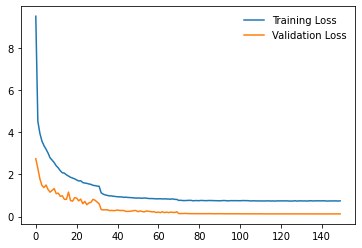

In [19]:
learning_rate = 0.001
criterion = RMSELoss_custom
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True, patience=5)
if gpu:
    model.cuda()

train_losses, val_losses = [], []
val_loss_min = np.inf
for e in range(1, epochs + 1):
    start = time.perf_counter()
    model.float().train()
    train_loss = 0
    for images, labels in train_loader:
        if gpu:
            images = images.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
            if gpu:
                images = images.cuda()
                labels = labels.cuda()
            prediction = model(images)
            loss = criterion(prediction, labels)
            val_loss += loss.item()
        scheduler.step(val_loss)
    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    print("Epoch: {}/{} ".format(e, epochs),
                  "Training Loss: {:.4f}".format(train_losses[-1]),
                  "Val Loss: {:.4f}".format(val_losses[-1]))
    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), dir + 'model_so_far.pt')
        print('Detected network improvement, saving current model')
    end = time.perf_counter()
    total = (end - start)*(epochs - e)
    print('Estimated time: {} hours, '
          '{} minutes, {} seconds'.format(total//3600,
                                          total%3600//60,int(total%60)), end="\r")

model = resnet50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
checkpoint = torch.load(dir + 'model_so_far.pt')
model.load_state_dict(checkpoint)

plt.tick_params(colors=frame_color)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(frameon=False)

## load the model

In [20]:
model = resnet50

checkpoint = torch.load(dir + 'model_so_far.pt',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.cpu()
print('Model is ready!')

Model is ready!


# Validation prediction visualization
## Some examples

<Figure size 1440x720 with 0 Axes>

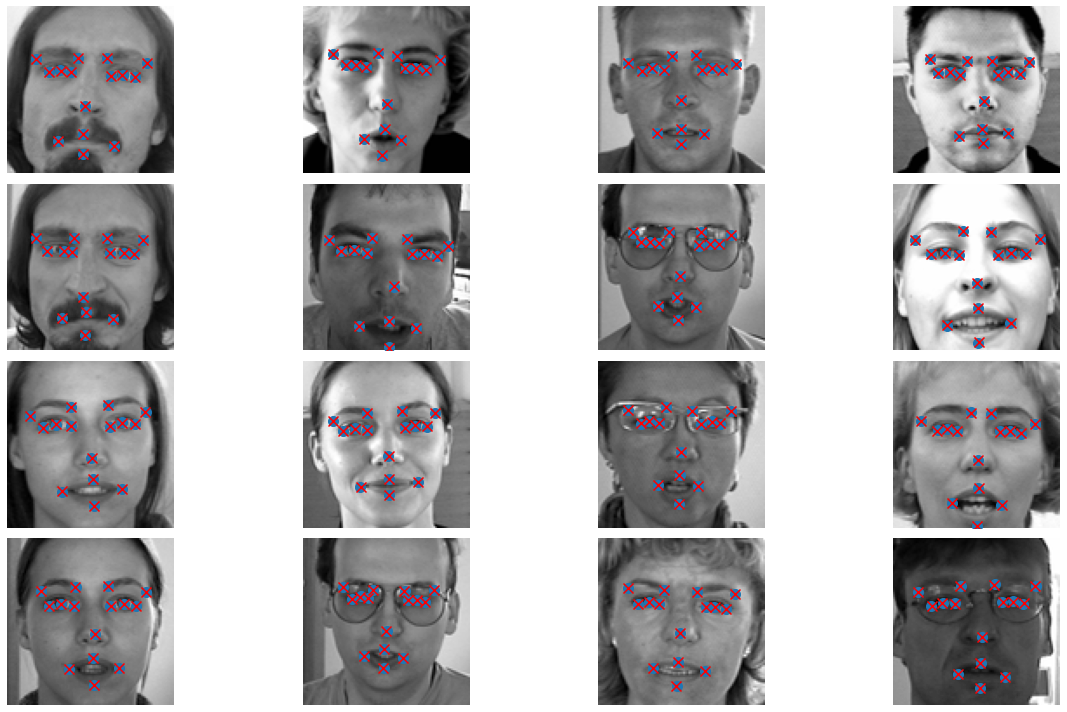

In [21]:
val_loader = torch.load(dir + 'val_loader.pt')
fig = plt.figure(figsize=(20,10))
images, labels = next(iter(val_loader))
with torch.no_grad():
    model.eval()
    predicted_labels = model(images)
visualize_examples(images, labels, predicted_labels)

<Figure size 1440x720 with 0 Axes>

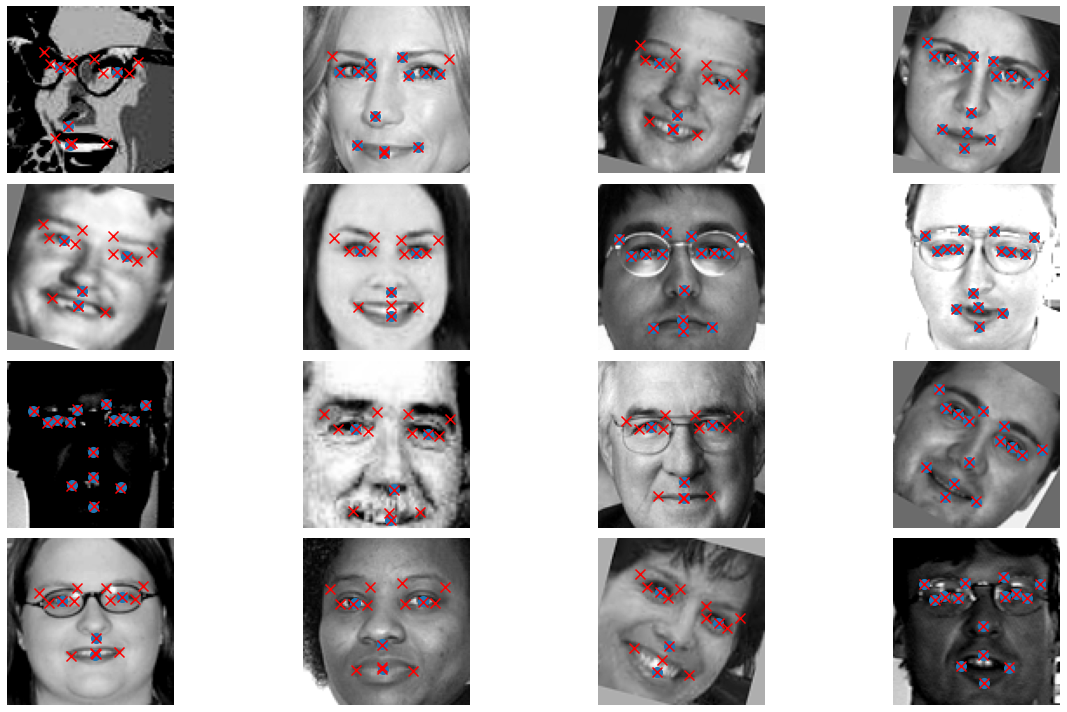

In [22]:
fig = plt.figure(figsize=(20,10))
images, labels = next(iter(train_loader))
with torch.no_grad():
    model.eval()
    predicted_labels = model(images)
visualize_examples(images, labels, predicted_labels)

# Test prediction
## Predict

In [23]:
test_csv = pd.read_csv(dir + 'test.csv')
test_data = FaceKeypointDataSet(test_csv,is_test_set=True)
test_sampler =  SequentialSampler(range(len(test_data)))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), sampler=test_sampler)
images = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    predicted_labels = model(images)

## Visualization

test set


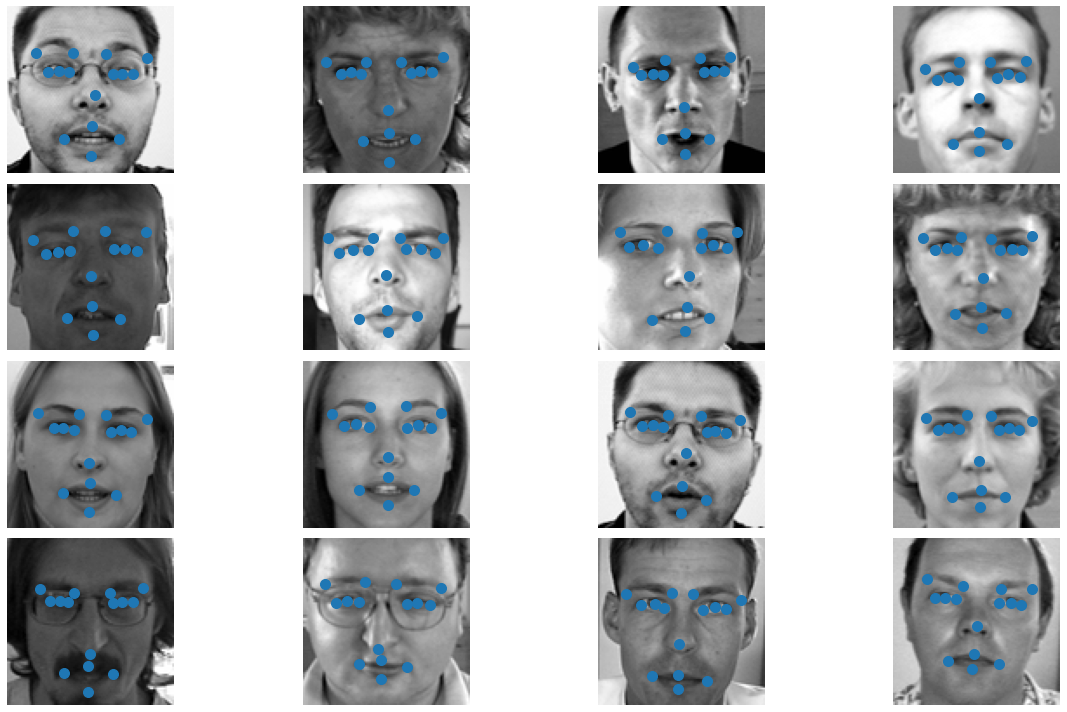

In [24]:
print('test set')
visualize_examples(images,predicted_labels)


# Submission

In [25]:
keypts_labels = train_and_val_csv.columns.tolist()
id_lookup = pd.read_csv(inp + 'facial-keypoints-detection/IdLookupTable.csv')
id_lookup_features = list(id_lookup['FeatureName'])
id_lookup_image = list(id_lookup['ImageId'])

for i in range(len(id_lookup_features)):
    id_lookup_features[i] = keypts_labels.index(id_lookup_features[i])

location = []
for i in range(len(id_lookup_features)):
    value = float(predicted_labels[id_lookup_image[i]-1][id_lookup_features[i]])
    if value < 0:
        print(id_lookup_image[i] - 1)
        value = 0
    if value > 96:
        print(id_lookup_image[i] - 1)
        value = 96
    location.append(value)
id_lookup['Location'] = location
submission = id_lookup[['RowId', 'Location']]
submission.to_csv('submission.csv',index=False)
print('Total test images labeled:')
print(len(submission) - 1)
print('Submission file is ready')


Total test images labeled:
27123
Submission file is ready
